# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
  1
  1
 -1
  1
  1
  1
  1
  1
 -1
  1
  ⋮
  1
  1
  1
  1
  1
  1
  1
  1
  1

### We create a function to visualize the data

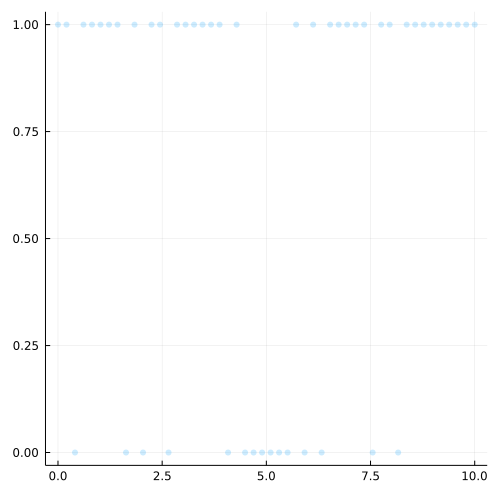

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  0.836001 seconds (1.85 M allocations: 98.304 MiB, 99.63% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink(LogExpFunctions.logistic)) infered by Analytic Variational Inference , (local_vars = (c = [1.0421569897825351, 1.0659115799301033, 1.0836947617467343, 1.0889913424870032, 1.0774173406509115, 1.049289869819842, 1.0096678780931216, 0.9673108410481478, 0.9322430136759846, 0.9134894940628359  …  1.2269598668662134, 1.2973156768233893, 1.3793987104302732, 1.462396949799971, 1.5331110240621684, 1.5791904078154557, 1.592001346929742, 1.568516884213133, 1.5118888006573379, 1.4306861725681403], θ = [0.22958727580555355, 0.22874189450764001, 0.22810163380077256, 0.22790974322409185, 0.22832835400484472, 0.22933463697997847, 0.23072453078030755, 0.23217269721059067, 0.23334057697067986, 0.23395309031638348  …  0.2227342917641055, 0.21997951178924108, 0.21668456762228747, 0.21327930718390822, 0.21033117184820488, 0.20839148198516505, 0.20785000773376355, 0.2088419186850859, 0.21121987158

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:04:24
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:14
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:29
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:07
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:00:53
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:44
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:38
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:33
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:29
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:26
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:24
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:22
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[0.4594683227083499, 0.5640504633864529, 0.6820414941591882, 0.813427071445501, 0.9165116327435621, 1.055569739329601, 1.1551184887755257, 1.3012523717054587, 1.4528068925173814, 1.6564005759733993  …  0.48342909904953435, 0.5130511228413036, 0.6185627216415066, 0.7859443910268558, 1.0575746954862018, 1.32100606506901, 1.5157399571934054, 1.6157955362521284, 1.5597013313458867, 1.3636376722446917]]
 [[0.028217377146052436, 0.03973752979284029, 0.08877410639305716, 0.13846620554309985, 0.22271018770025763, 0.27879692457748356, 0.33474539622093324, 0.3319204677547842, 0.2716094989183679, 0.1922760665657443  …  1.0164359961971492, 0.8415398339223081, 0.6895472250889763, 0.6843298902538518, 0.7703761121684173, 0.9623355602341906, 1.2711330008874966, 1.5947193510880164, 1.9276088293301652, 2.1677175073978066]]
 [[0.6574477908579115, 0.6669618014010077, 0.6464570076715859, 0.6772126371710298, 0.703280052344123, 0.7373671647285904, 0.79062281949

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

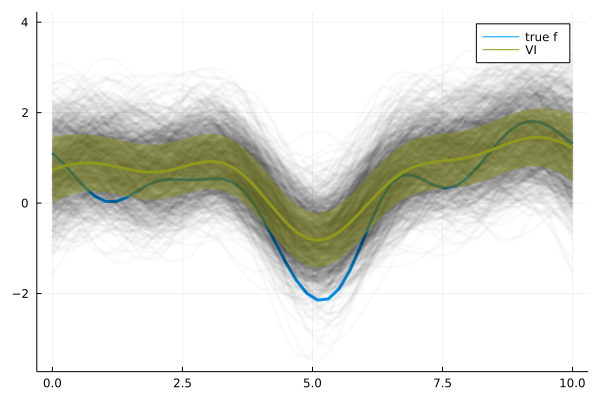

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

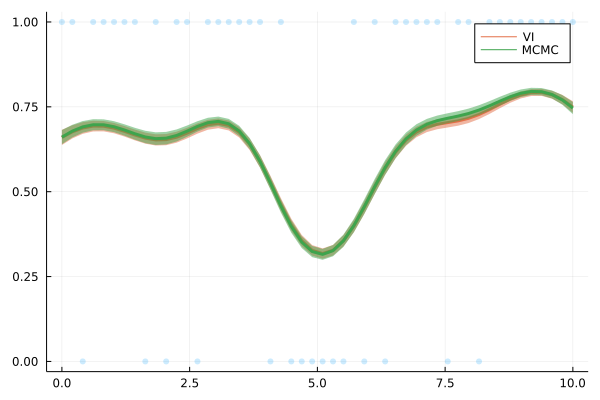

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*